# Modèles de prédiction

In [1]:
import pandas as pd
from pathlib import Path
from ase.io import read
import numpy as np
import os

csv_path = "/home/gris/N7/Semestre_10/App_cont_phys/Projet_Molecules/data/energies/train.csv"
energy_data = pd.read_csv(csv_path)

# def extract_features_from_xyz(file_path):
#     atoms = read(file_path)
#     num_atoms = len(atoms)
#     sum_positions = np.sum(atoms.get_positions())
#     return np.array([num_atoms, sum_positions])

def extract_features_from_xyz(file_path):
    atoms = read(file_path)

    # Nombre d'atomes
    num_atoms = len(atoms)

    # Types d'atomes et leur nombre
    atom_types = atoms.get_chemical_symbols()
    unique_types, counts = np.unique(atom_types, return_counts=True)
    type_counts = {type_: count for type_, count in zip(unique_types, counts)}

    # Positions atomiques
    positions = atoms.get_positions()

    # Calculer le centre de masse
    masses = atoms.get_masses()
    center_of_mass = np.average(positions, axis=0, weights=masses)

    # Calculer le rayon de gyration
    distances_from_com = positions - center_of_mass
    squared_distances = np.sum(distances_from_com**2, axis=1)
    radius_of_gyration = np.sqrt(np.sum(squared_distances * masses) / np.sum(masses))

    # Calculer les distances interatomiques
    distances = atoms.get_all_distances()

    # Caractéristiques basées sur les distances
    mean_distance = np.mean(distances)
    max_distance = np.max(distances)
    min_distance = np.min(distances)

    # Retourner les caractéristiques
    features = np.array([
        num_atoms,
        radius_of_gyration,
        mean_distance,
        max_distance,
        min_distance,
        *center_of_mass
    ])

    return features

X = []
y = []

data_dir = Path("../../data/atoms/train")

xyz_files = list(data_dir.glob("*.xyz"))

for xyz_file in xyz_files:
    molecule_id = xyz_file.stem

    numeric_id = int(molecule_id.split('_')[-1])

    # Vérifiez si l'identifiant numérique de la molécule est dans le fichier CSV
    energy = energy_data.loc[energy_data['id'] == numeric_id, 'energy'].values
    if len(energy) > 0:
        features = extract_features_from_xyz(xyz_file)
        X.append(features)
        y.append(energy[0])
        #print(f"Molécule {molecule_id} chargée avec succès avec énergie {energy[0]}.")
    else:
        print(f"Aucune énergie trouvée pour la molécule {molecule_id}.")

X = np.array(X)
y = np.array(y)

In [5]:
print(X.shape)

(6591, 8)


Mean Squared Error: 6.179632420880832
Root Mean Squared Error: 2.4858866468286185


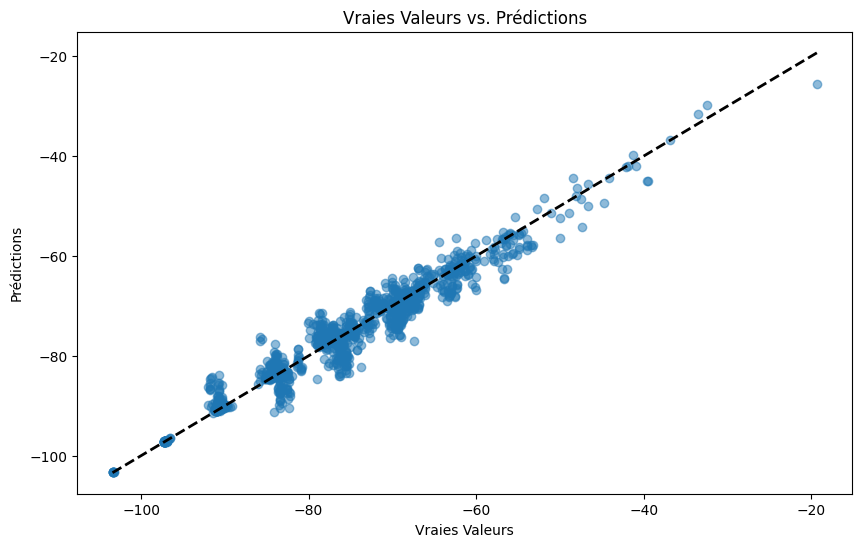

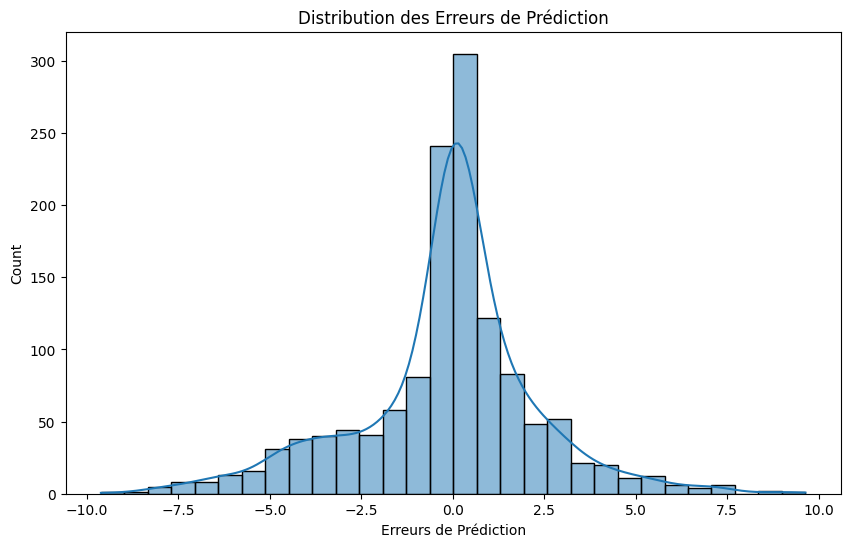

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.title('Vraies Valeurs vs. Prédictions')
plt.show()

errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Erreurs de Prédiction')
plt.title('Distribution des Erreurs de Prédiction')
plt.show()


In [ ]:
import numpy as np
from ase.io import read
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def extract_invariant_features_from_xyz(file_path):
    atoms = read(file_path)

    # Centrer les positions des atomes (invariance par translation)
    positions = atoms.get_positions()
    center_of_mass = np.mean(positions, axis=0)
    centered_positions = positions - center_of_mass

    # Calculer les distances interatomiques (invariance par rotation)
    distances = []
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            distances.append(np.linalg.norm(centered_positions[i] - centered_positions[j]))

    # Caractéristiques basées sur les distances
    mean_distance = np.mean(distances)
    max_distance = np.max(distances)
    min_distance = np.min(distances)

    # Caractéristiques basées sur les types d'atomes (invariance par permutation)
    atom_types = atoms.get_chemical_symbols()
    unique_types, counts = np.unique(atom_types, return_counts=True)
    type_counts = {type_: count for type_, count in zip(unique_types, counts)}

    # Retourner les caractéristiques sous forme de tableau
    features = np.array([
        len(atoms),
        mean_distance,
        max_distance,
        min_distance,
        *list(type_counts.values())
    ])

    return features


X = []
y = []

data_dir = Path("../../data/atoms/train")

xyz_files = list(data_dir.glob("*.xyz"))

for xyz_file in xyz_files:
    molecule_id = xyz_file.stem

    numeric_id = int(molecule_id.split('_')[-1])

    # Vérifiez si l'identifiant numérique de la molécule est dans le fichier CSV
    energy = energy_data.loc[energy_data['id'] == numeric_id, 'energy'].values
    if len(energy) > 0:
        features = extract_features_from_xyz(xyz_file)
        X.append(features)
        y.append(energy[0])
        #print(f"Molécule {molecule_id} chargée avec succès avec énergie {energy[0]}.")
    else:
        print(f"Aucune énergie trouvée pour la molécule {molecule_id}.")

X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédire et évaluer le modèle
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 2.4858866468286185


Mean Squared Error: 6.179632420880832
Root Mean Squared Error: 2.4858866468286185


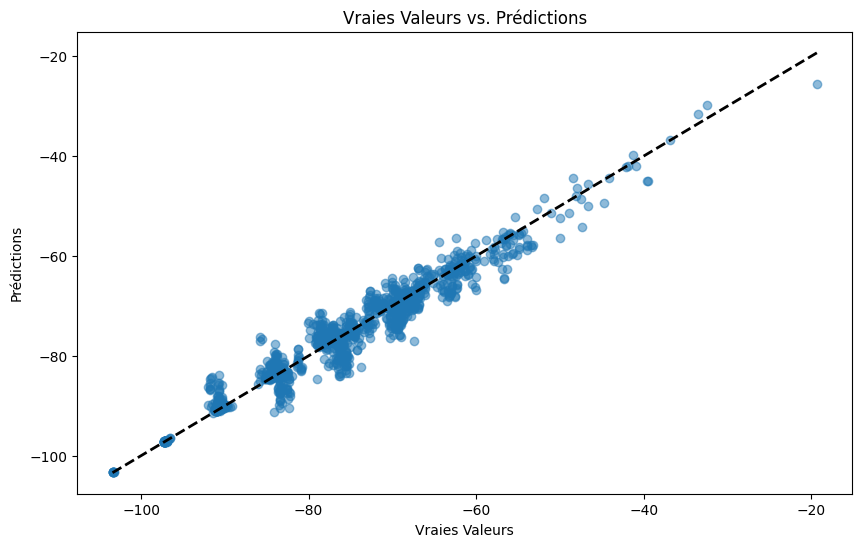

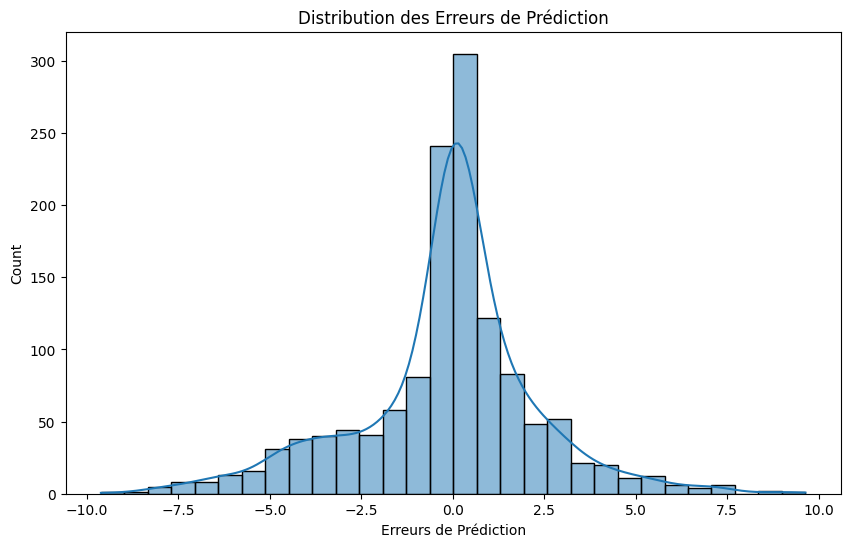

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.title('Vraies Valeurs vs. Prédictions')
plt.show()

errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Erreurs de Prédiction')
plt.title('Distribution des Erreurs de Prédiction')
plt.show()
